# Test via point, and end point of grasping task in the pybullet working space

In [1]:
import os, time, tqdm, sys
import torch.nn as nn
import numpy as np
import torch

# add parent dictionary to path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from models.vae import TrajGen, DM
from models.dmp import CanonicalSystem, SingleDMP
from utils.data_loader import TorqueLoader as Torque_dataset
from utils.early_stop import EarlyStop
from matplotlib import pyplot as plt
from collections import OrderedDict
print(os.getcwd())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/home/binzhao/Documents/code/VAE_DMP_mani/manipulation_task
cuda


create cVAE-dmp model

In [2]:
# create dmp model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
run_time = 1
dt = 0.01
# define the shape of each damonstration
shape = (5, 100)
# create dataset for training and testing
cs = CanonicalSystem(dt=0.01, ax=1)
dmp = SingleDMP(n_bfs=50, cs=cs, run_time=1.0, dt=0.01)
print("device: ", device) 

device:  cuda


In [3]:
# get max, min from dataset to de-normalize the data
train_dataset = Torque_dataset(run_time=1, dmp=dmp, dt=0.01, dof=2)
train_dataset.load_data('../data/manipulation_data/train_torque.npz', device=device)
train_dataset.torque = train_dataset.normalize_data(device=device)

#get normalize  paramters of data
max = train_dataset.max.cpu().numpy()
min = train_dataset.min.cpu().numpy()
print(max, min)

[ 9.639522 40.198143 65.1502   54.927094 89.87197 ] [-35.03298   -13.038735   -6.0426774  -4.746726  -25.30069  ]


In [4]:
# load pretrained model
save_name = "./models/cVAE_torque_manipulation.pt"
checkpoint = torch.load(save_name, map_location=device)
dict = checkpoint['net']

/tmp/ipykernel_39084/3714809421.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_name, map_location=device)


In [5]:
# load the decoder part only -- generator
decoder_param = OrderedDict() 
    
key_word_1 = {"decoder."}
key_word_2 = {"label_embedding."}

for layer_name, param in checkpoint["net"].items():
    for key_word in key_word_1:
        if key_word in layer_name:            
            layer_name = layer_name.replace(key_word, "")            
            decoder_param[layer_name] = param

torch.save(decoder_param, "./models/decoder.pt")

# save label encoder
label_encoder_param = OrderedDict()
for layer_name, param in checkpoint["net"].items():
    for key_word in key_word_2:
        if key_word in layer_name:            
            layer_name = layer_name.replace(key_word, "")            
            label_encoder_param[layer_name] = param

torch.save(label_encoder_param, "./models/label_encoder.pt")

In [6]:
# create trajectory generator -- decoder + dynamics system
shape = (5, 100)
nclass = 4
nhid = 8
ncond = 8

# create trajectory generator
traj_gen = TrajGen(shape=shape, nclass=nclass, nhid=nhid, ncond=ncond, min=min, max=max, device=device)
# send to device
traj_gen.decoder_o.load_state_dict(torch.load('./models/decoder.pt'))
traj_gen.decoder_n.load_state_dict(torch.load('./models/decoder.pt'))
traj_gen.label_embedding.load_state_dict(torch.load('./models/label_encoder.pt'))

/tmp/ipykernel_39084/1204908132.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  traj_gen.decoder_o.load_state_dict(torch.load('./models/decoder.pt'))
/tmp/ipykernel_390

<All keys matched successfully>

Create pybullet based environment and load demonstration data

In [7]:
robot_model_path = "../manipulation_env/models/urdf/ur10_robotiq_85.urdf"
table_path = "../manipulation_env/models/urdf/objects/table/table.urdf"
block_path = "../manipulation_env/models/YcbPottedMeatCan/model.urdf"

demon_path = "../data/manipulation_data"

# create dictionary to store the data
demons_data = {}
for file in os.listdir(demon_path):

    if file.endswith(".npy"):
        data = np.load(os.path.join(demon_path, file), allow_pickle=True)
        task_id = int(file.split("_")[0])
        demons_data["task_id_" + str(task_id)] = data
print("Number of demonstrations: ", len(demons_data))  

# show the structure of the data
for key, value in demons_data.items():
    print(key, value.shape)

Number of demonstrations:  3
task_id_2 (33, 5)
task_id_3 (35, 5)
task_id_1 (19, 5)


In [8]:
# create pybullet environment
from manipulation_env.env import ManiEnv
from manipulation_env.robot import UR10Robotiq85
robot = UR10Robotiq85(model_path=robot_model_path)
env = ManiEnv(robot, block_path=block_path, table_path=table_path, vis=True)
env.reset()

pybullet build time: Nov 28 2023 23:51:11
0it [00:00, ?it/s]

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Graphics (RPL-P)
GL_VERSION=4.6 (Core Profile) Mesa 24.0.9-0ubuntu0.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 24.0.9-0ubuntu0.1
Vendor = Intel
Renderer = Mesa Intel(R) Graphics (RPL-P)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
[jointInfo(id=0, name='world_arm

1it [00:01,  1.71s/it]

Task 3: grasping task, test basic cVAE-dmp model, and end point fine-tuning

In [17]:
# get the grasping trajectory
env.clean_traj_plot()
gripper_offset = 0.17
grasping_demo = demons_data["task_id_3"]
block_position = np.array([0, 0, 0.04])

# relay the trajectory
position = grasping_demo[20]
block_position[0] = position[0]
block_position[1] = position[1]
env.reset_block(pos = block_position, euler_angle=[0, 0, 0])

# # draw the inital trajectory 
env.traj_plot(grasping_demo[:, :3], color=[0.96, 0, 0.63])

In [10]:
# replay the grasping demo
env.reset_block(pos = block_position, euler_angle=[0, 0, 0])
# for i in range(grasping_demo.shape[0]):
#     env.step(grasping_demo[i])
#     time.sleep(0.01)

# # reset 
# env.step(grasping_demo[0])
# env.reset_block(pos = block_position, euler_angle=[0, 0, 0])

In [11]:
# random put the block position and orientation
robot_initial_pose = grasping_demo[0]
robot_end_pose = grasping_demo[-1]

block_position = np.array([0, 0, 0.04])
env.clean_traj_plot()
env.step(robot_initial_pose)

tractories = []
# random put the block and collect the trajectory
for num_traj in range(30): 

    random_x = np.random.rand() * 0.3 + 0.5
    random_y = (np.random.rand() - 0.5) * 0.8
    block_position[0] = random_x
    block_position[1] = random_y
    block_orien = np.random.rand() * np.pi/2

    # set the final position of the robot
    env.reset_block(pos = block_position, euler_angle=[0, 0, block_orien])
    
    # get the grasping state
    block_pos_sim = env.get_block_position()
    grasp_point = block_pos_sim + np.array([0, 0, gripper_offset])
    robot_end_pose[:3] = grasp_point
    robot_end_pose[3] = block_orien
    robot_end_pose[4] = 0.55

    # get the trajectory
    torch_robot_inial_pose = torch.tensor(robot_initial_pose, dtype=torch.float32).to(device)
    torch_robot_end_pose = torch.tensor(robot_end_pose, dtype=torch.float32).to(device)

    with torch.no_grad():
        traj = traj_gen(class_idx=3, x0=torch_robot_inial_pose, goal=torch_robot_end_pose)
    
    # convert to numpy
    traj = traj.cpu().numpy()[0]
    print(traj.shape)

    # plot the trajectory
    env.traj_plot(traj[:3,:].T)

    # check if touch the block
    success = False
    env.step(robot_initial_pose)
    for i in range(traj.shape[1]):
        env.step(traj[:, i])
        if env.check_grasping():
            success = True
            break
    
    # store the trajectory
    tractories.append({"traj":traj, "success":success, "block_pose":block_pos_sim, block_orien:block_orien})  
    print("Trajectory: ", num_traj, "Success: ", success)  

3486it [02:29,  6.95it/s] /home/binzhao/Documents/code/VAE_DMP_mani/models/vae.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x0).to(self.device)
/home/binzhao/Documents/code/VAE_DMP_mani/models/vae.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goal = torch.tensor(goal).to(self.device)


(5, 100)


14158it [03:18, 224.47it/s]

Trajectory:  0 Success:  True
(5, 100)


24830it [04:07, 226.45it/s]

Trajectory:  1 Success:  True
(5, 100)


36955it [05:03, 224.92it/s]

Trajectory:  2 Success:  False
(5, 100)


47650it [05:52, 225.52it/s]

Trajectory:  3 Success:  True
(5, 100)


58437it [06:42, 224.38it/s]

Trajectory:  4 Success:  True
(5, 100)


69247it [07:31, 224.43it/s]

Trajectory:  5 Success:  True
(5, 100)


79919it [08:20, 223.98it/s]

Trajectory:  6 Success:  True
(5, 100)


90729it [09:10, 224.56it/s]

Trajectory:  7 Success:  True
(5, 100)


101516it [09:58, 225.05it/s]

Trajectory:  8 Success:  True
(5, 100)


112188it [10:47, 223.63it/s]

Trajectory:  9 Success:  True
(5, 100)


122883it [11:35, 226.75it/s]

Trajectory:  10 Success:  True
(5, 100)


133555it [12:24, 224.53it/s]

Trajectory:  11 Success:  True
(5, 100)


144250it [13:12, 224.28it/s]

Trajectory:  12 Success:  True
(5, 100)


155037it [14:01, 225.00it/s]

Trajectory:  13 Success:  True
(5, 100)


165709it [14:50, 226.79it/s]

Trajectory:  14 Success:  True
(5, 100)


176519it [15:39, 223.93it/s]

Trajectory:  15 Success:  True
(5, 100)


187329it [16:28, 225.22it/s]

Trajectory:  16 Success:  True
(5, 100)


198116it [17:17, 224.99it/s]

Trajectory:  17 Success:  True
(5, 100)


208788it [18:06, 224.73it/s]

Trajectory:  18 Success:  True
(5, 100)


219598it [18:55, 224.79it/s]

Trajectory:  19 Success:  True
(5, 100)


230408it [19:44, 224.11it/s]

Trajectory:  20 Success:  True
(5, 100)


242529it [20:38, 225.02it/s]

Trajectory:  21 Success:  False
(5, 100)


253316it [21:27, 225.16it/s]

Trajectory:  22 Success:  True
(5, 100)


263988it [22:16, 224.50it/s]

Trajectory:  23 Success:  True
(5, 100)


274683it [23:04, 224.82it/s]

Trajectory:  24 Success:  True
(5, 100)


285470it [23:53, 224.12it/s]

Trajectory:  25 Success:  True
(5, 100)


296280it [24:42, 226.27it/s]

Trajectory:  26 Success:  True
(5, 100)


306952it [25:30, 225.71it/s]

Trajectory:  27 Success:  True
(5, 100)


317631it [26:18, 226.78it/s]

Trajectory:  28 Success:  True
(5, 100)


329650it [27:12, 226.56it/s]

Trajectory:  29 Success:  True


329650it [27:30, 226.56it/s]

Generate an initial trajectory

Success rate:  0.9333333333333333


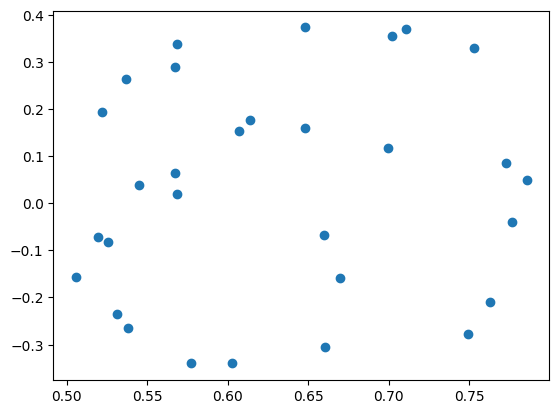

In [13]:
# save the data
np.savez("grasping_trajecotries.npz", tractories=tractories)

# print the success in the pushing
success = 0
for traj in tractories:
    if traj["success"]:
        success += 1
print("Success rate: ", success/len(tractories))

# matplt plot the block position
block_pos = []
for traj in tractories:
    block_pos.append(traj["block_pose"])
block_pos = np.array(block_pos)
plt.scatter(block_pos[:,0], block_pos[:,1])